<a href="https://colab.research.google.com/github/yellayujin/studying/blob/main/240220_ML3(%EB%8B%B9%EB%87%A8%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('./data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())  # 데이터 클래스 불균형
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


# idea
- 이진분류

- 클래스 불균형
    - 데이터셋 분리: 층화추출
    - 평가지표: f1-score
- Insulin의 분포가 특이. 0이 매우 많고, 최댓값 또한 매우 큼. 0을 others, 구간화할까?
- 다른 변수들도 분포 확인해봐야

In [ ]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# 수정된 get_clf_eval() 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [ ]:
# 독립변수, 종속변수
X = diabetes_data.iloc[:, :-1] # 맨 마지막 컬럼 제외한 모든 컬럼 추출(drop이 나은듯)
y = diabetes_data['Outcome']

print(X.shape, y.shape)

(768, 8) (768,)


# 데이터셋 분리(훈련, ...)
- stratify = y: y대상 층화추출

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(537, 8) (231, 8) (537,) (231,)


# 로지스틱 회귀

In [ ]:
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_tr, y_tr)

LogisticRegression(solver='liblinear')

In [ ]:
pred = lr_clf.predict(X_te)
pred  # label로 다이렉트 예측
pred_proba = lr_clf.predict_proba(X_te)[:, 1]   # 1일 확률을 확률값으로 내보냄
# 그냥 predict말고 predict_proba로 실행하는 것을 권장(최적의 임계값 찾기 위함)
# lr_clf.predict_proba(X_te)  # 0일 확률과 1일 확률 각각 내보냄

In [ ]:
get_clf_eval(y_te, pred, pred_proba)

오차 행렬
[[136  14]
 [ 35  46]]
정확도: 0.7879, 정밀도: 0.7667, 재현율: 0.5679,    F1: 0.6525, AUC:0.8677


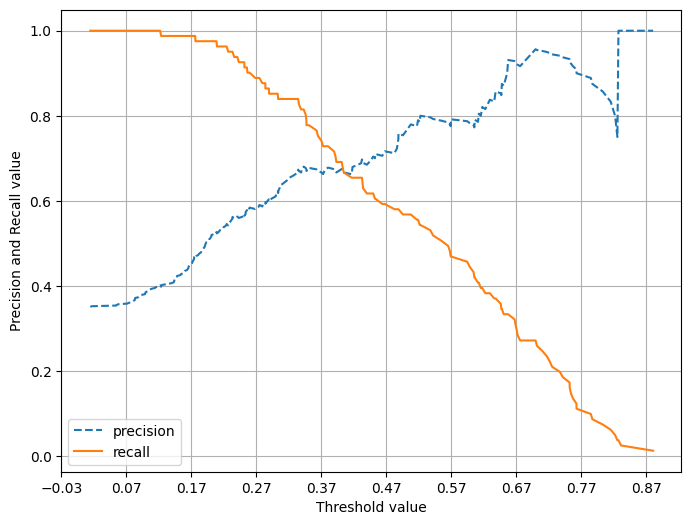

In [ ]:
pred_proba_c1 = lr_clf.predict_proba(X_te)[:, 1]
precision_recall_curve_plot(y_te, pred_proba_c1)   # 교점 대략 0.42정도?

# 임계값 조작 전, 데이터 재가공
- 모델 성능 업그레이드 Tip: 하이퍼파라미터 튜닝(지난 시간), 교차검증(지난 시간), 데이터 재가공(이번 시간)
- 모델링 엄청 많이 수행함->반드시 각 시행착오(모델알고리즘, 데이터재가공, 교차검증, 하이퍼파라미터 튜닝) 표로 정리!

In [ ]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']
# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()
# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))


Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [ ]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [ ]:
# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 156, stratify=y)
# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[133  17]
 [ 30  51]]
정확도: 0.7965, 정밀도: 0.7500, 재현율: 0.6296,    F1: 0.6846, AUC:0.8178


# 임계값 조작

In [ ]:
from sklearn.preprocessing import Binarizer

# 최적의 임곗값 찾는 함수
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [ ]:
thresholds = [0.3 , 0.33 ,0.36, 0.39, 0.42 , 0.45 ,0.48, 0.50]   # 임계값 후보군
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

# 0.5쯤으로 결정

임곗값: 0.3
오차 행렬
[[112  38]
 [ 19  62]]
정확도: 0.7532, 정밀도: 0.6200, 재현율: 0.7654,    F1: 0.6851, AUC:0.8178
임곗값: 0.33
오차 행렬
[[117  33]
 [ 24  57]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8178
임곗값: 0.36
오차 행렬
[[120  30]
 [ 26  55]]
정확도: 0.7576, 정밀도: 0.6471, 재현율: 0.6790,    F1: 0.6627, AUC:0.8178
임곗값: 0.39
오차 행렬
[[126  24]
 [ 27  54]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8178
임곗값: 0.42
오차 행렬
[[128  22]
 [ 28  53]]
정확도: 0.7835, 정밀도: 0.7067, 재현율: 0.6543,    F1: 0.6795, AUC:0.8178
임곗값: 0.45
오차 행렬
[[132  18]
 [ 29  52]]
정확도: 0.7965, 정밀도: 0.7429, 재현율: 0.6420,    F1: 0.6887, AUC:0.8178
임곗값: 0.48
오차 행렬
[[133  17]
 [ 29  52]]
정확도: 0.8009, 정밀도: 0.7536, 재현율: 0.6420,    F1: 0.6933, AUC:0.8178
임곗값: 0.5
오차 행렬
[[133  17]
 [ 30  51]]
정확도: 0.7965, 정밀도: 0.7500, 재현율: 0.6296,    F1: 0.6846, AUC:0.8178
